In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'news-articles:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1192%2F2143%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240520T172514Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D75d7de9f57fa1e927dd36911b833cbbb8a6545b1de83e7082b4f7ec1232105d8a82fcd5c0b1070772d6ee90ab90b185c065056bb04dddf38a94308fe9537e8d0da32eaf6e0ed433edb918f8562ccaeadcefcf33d11a36689787c28c5398d43b4a223ec67fcdee84abd56a30fe27bf676be6baa15d89a7b49442a9cb7a25a63ef8983bc97534d2a27f67f510b72cbeb592c9ade48b133a71f2a3abfc3de7b9ed2b7df0695bc64dc8942eb634b3c0d65bd097b03d013e966125249504da3512765412781379ab7c119d0d8aab83aed031f5b44ffd896b08660e3bb35f7e32a310bda40db4c93b93e611d0e5101297a69547716c9cd416ecbbac04762a82aeb8d8e,thesis2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4973748%2F8367137%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240520T172514Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D08a5fd4aa4c368dc0bc923f6ca1535d43c72c36c0724e35339d214785a8cc37cb486aea3d6bd10304ee2b3265aaf54f90fcc7a5f1c60d0862554066d1c4315974f983c63721d99fcd58cb946fa28c5a8646618148693556ff701267d543738e652fb51cd011b70cbaba62ed047eeea1f16562b497dc992d1dec0a45435f2a9cbafd74ef5e800ff12da20d539084f07537680bcc2d5ef1488bf027d76eb5633f3089120ae0438ba02bb59199803a5477b2ce5fcf93ada0e121ed54698136bc434d14a64fa25293002ee81dccba507cbc6e6a0dcab848a560d83cf5c069465d7afd8af7764c7fc38af5fc001559c285c9afa6aa0f1d2edad7c951039a5940fe2b3,kalpurushfont:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4973762%2F8367156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240520T172514Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6e5bd21c00ac58f239f18374188708db8dc5d749247d01b61f089affb5cbf0d36da091f82fb324676a0efe80462e915a0c6532e80a0862cbd72c9320433be50d26ec65f6bde6eb18383b2ab8748ad122723f6cb8c4d97a6a6afc753967a9756ccaffe089c63187aef0207e3639788d37aefcffbfa87e8e691ccf84e573ee09f7afe0e03be1f33912a5b1bcd2586623c409dffc939a650a6f4b857e37306e2ef7c5832795ceaf49b65b2fd2166608a83261dcdd786a83075d5bc1f92eddc66e24c79cd6c6a73a68e3d0ad3ebdaab114fbc6df41dfb217bea976817f7dab660135b6d431b4d526e25170bd2023c12cda501b3f63443636985c342f97846a6f1f3e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/thesis2/merged.csv
/kaggle/input/news-articles/Articles.csv
/kaggle/input/kalpurushfont/Siyamrupali.ttf


In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 5.12 s, sys: 1.2 s, total: 6.32 s
Wall time: 11.9 s


In [ ]:
import pandas as pd
data = pd.read_csv("/kaggle/input/thesis2/merged.csv")
print(f'Total number of Documents: {len(data)}')

Total number of Documents: 7300


In [ ]:
import pandas as pd

# Assuming your dataset is stored in a DataFrame called 'df'
# Replace 'clean text' with the actual column name in your dataset
duplicates = data[data.duplicated(subset='text', keep=False)]

# 'duplicates' now contains all rows where the 'clean text' column has duplicate values
# You can inspect these entries to understand why they are duplicated

# To print the count of duplicated rows:
print(f"Number of duplicated rows: {len(duplicates)}")

Number of duplicated rows: 0


In [ ]:
data = data[['text','label']]

In [ ]:
data = data.rename(columns={0:'text',1:'label'})

In [ ]:
total_categories = data['label'].nunique()
print("Total number of categories:", total_categories)

Total number of categories: 6


In [ ]:
# Assuming 'data' is your DataFrame with columns renamed
category_names = data['label'].unique()
print("Category names:", category_names)

Category names: ['Software Engineering' 'DBMS' 'Data Communication' 'Cyber Security '
 'Operating System' 'Cyber Security']


In [ ]:
# Replace 'Cyber Security' and 'Cyber Security ' with 'Cyber Security'
data['label'] = data['label'].replace(['Cyber Security ', 'Cyber Security  '], 'Cyber Security')

# Replace 'Operating System' and 'operating System' with 'Operating System'
data['label'] = data['label'].replace(['Operating System', 'operating System'], 'Operating System')

In [ ]:
# Assuming 'data' is your DataFrame with the 'label' column containing category names
unique_classes = data['label'].unique()
print("Unique classes:", unique_classes)

Unique classes: ['Software Engineering' 'DBMS' 'Data Communication' 'Cyber Security'
 'Operating System']


In [ ]:
print("First rows of dataset")
data.head()

First rows of dataset


,text,label
0,সফটওয়্যার ইঞ্জিনিয়ারিং দুইটি শব্দ সফটওয়্যার...,Software Engineering
1,সফটওয়্যার কিছু প্রোগ্রামের সমষ্টি,Software Engineering
2,সমস্ত প্রোগ্রাম যখন কোন নির্ধারিত সমস্যা সমাধা...,Software Engineering
3,অপরদিকে ইঞ্জিনিয়ারিং বলতে যে সকল নীতিমালা ও ম...,Software Engineering
4,সফটওয়্যার ইঞ্জিনিয়ারিং বলতে কী বুঝায়,Software Engineering


In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    #english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    #text=english_pattern.sub(r'', text)
    text = re.sub(r'₀|₁|₂|₃|₄|₅|₆|₇|₈|₉', '', text)
    #text = re.sub(r'⁰|¹|²|³|⁴|⁵|⁶|⁷|⁸|⁹|⁻|⁺|ⁿ|ᵗ', '', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=৳০১২৩৪৫৬৭৮৯012–34567•89।!()-−[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰θ→°π∈∝α≤≥Δβε≠�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out


In [ ]:
data['cleaned'] = data['text'].apply(lambda x: preprocessing(str(x)))

In [ ]:
sample_data = range(4000, 5000)
for i in sample_data:
    print(data['cleaned'][i])

গ্রে হ্যাট হ্যাকাররা  আবার তা নিজের স্বার্থের জন্যও ব্যবহার করতে পারে
ব্ল্যাক হ্যাট হ্যাকার Black Hat Hacker এই ধরনের হ্যাকাররা সবচেয়ে ভয়ংকর প্রকৃতির হ্যাকার 
ব্ল্যাক হ্যাট হ্যাকার  কোনো একটি সিকিউরিটি সিস্টেমের ত্রুটিগুলো বের করলে দ্রুত ঐ ত্রুটিকে নিজের স্বার্থে কাজে লাগায় 
ব্ল্যাক হ্যাট হ্যাকার  এরা সিস্টেম নষ্ট করে বিভিন্ন ভাইরাস ছড়িয়ে দেয় 
ব্ল্যাক হ্যাট হ্যাকার  তারা ভবিষ্যতে নিজে আবার যেন ঢুকতে পারে সে পথ রাখে 
ব্ল্যাক হ্যাট হ্যাকার  সর্বোপরি ঐ সিস্টেমের অধীনে যেসকল সাবসিস্টেম রয়েছে সেগুলোতেও ঢুকতে চেষ্টা করে
ব্লাক হ্যাট হ্যাকারদের কারণেই সবচেয়ে বেশি সাইবার ক্রাইম হয় এবং ইন্টারনেটে ধবংসাত্মক ভাইরাস এরাই তৈরি করে থাকে
ক্রাক্যাররাও  একধরনের হ্যাকার তবে এরা বিভিন্ন সিস্টেমে ঢুকে সেটির অনেক কিছু পরিবর্তন করে এবং কম্পিউটার ভাইরাস দিয়ে সকল তথ্য মুছে দেয় 
 অনেক সময় বিভিন্ন ওয়েবসাইট হ্যাক করে তার বিনিময়ে টাকা দাবি করা হয় এ ধরনের হ্যাকারকে ক্র্যাকার বলা হয়
পৃথিবীর বিভিন্ন দেশে যেসব সাইবার আইন করা হয়েছে তা মূলত এসব ক্র্যাকারদের জন্যই করা হয়েছে 
ক্র্যাকাররা বিভিন্নভাবে কাজ করে থাকে
তারা অনেক

In [ ]:
stop =["অতএব","অথচ","অথবা","অনুযায়ী","অনেক","অনেকে","অনেকেই","অন্তত","অন্য","অবধি","অবশ্য","অর্থাত","আই","আগামী","আগে","আগেই","আছে","আজ","আদ্যভাগে","আপনার","আপনি","আবার","আমরা","আমাকে","আমাদের","আমার","আমি","আর","আরও","ই","ইত্যাদি","ইহা","উচিত","উত্তর","উনি","উপর","উপরে","এ","এঁদের","এঁরা","এই","একই","একটি","একবার","একে","এক্","এখন","এখনও","এখানে","এখানেই","এটা","এটাই","এটি","এত","এতটাই","এতে","এদের","এব","এবং","এবার","এমন","এমনকী","এমনি","এর","এরা","এল","এস","এসে","ঐ","ও","ওঁদের","ওঁর","ওঁরা","ওই","ওকে","ওখানে","ওদের","ওর","ওরা","কখনও","কত","কবে","কমনে","কয়েক","কয়েকটি","করছে","করছেন","করতে","করবে","করবেন","করলে","করলেন","করা","করাই","করায়","করার","করি","করিতে","করিয়া","করিয়ে","করে","করেই","করেছিলেন","করেছে","করেছেন","করেন","কাউকে","কাছ","কাছে","কাজ","কাজে","কারও","কারণ","কি","কিংবা","কিছু","কিছুই","কিন্তু","কী","কে","কেউ","কেউই","কেখা","কেন","কোটি","কোন","কোনও","কোনো","ক্ষেত্রে","কয়েক","খুব","গিয়ে","গিয়েছে","গিয়ে","গুলি","গেছে","গেল","গেলে","গোটা","চলে","চান","চায়","চার","চালু","চেয়ে","চেষ্টা","ছাড়া","ছাড়াও","ছিল","ছিলেন","জন","জনকে","জনের","জন্য","জন্যওজে","জানতে","জানা","জানানো","জানায়","জানিয়ে","জানিয়েছে","জে","জ্নজন","টি","ঠিক","তখন","তত","তথা","তবু","তবে","তা","তাঁকে","তাঁদের","তাঁর","তাঁরা","তাঁাহারা","তাই","তাও","তাকে","তাতে","তাদের","তার","তারপর","তারা","তারৈ","তাহলে","তাহা","তাহাতে","তাহার","তিনঐ","তিনি","তিনিও","তুমি","তুলে","তেমন","তো","তোমার","থাকবে","থাকবেন","থাকা","থাকায়","থাকে","থাকেন","থেকে","থেকেই","থেকেও","দিকে","দিতে","দিন","দিয়ে","দিয়েছে","দিয়েছেন","দিলেন","দু","দুই","দুটি","দুটো","দেওয়া","দেওয়ার","দেওয়া","দেখতে","দেখা","দেখে","দেন","দেয়","দ্বারা","ধরা","ধরে","ধামার","নতুন","নয়","না","নাই","নাকি","নাগাদ","নানা","নিজে","নিজেই","নিজেদের","নিজের","নিতে","নিয়ে","নিয়ে","নেই","নেওয়া","নেওয়ার","নেওয়া","নয়","পক্ষে","পর","পরে","পরেই","পরেও","পর্যন্ত","পাওয়া","পাচ","পারি","পারে","পারেন","পি","পেয়ে","পেয়্র্","প্রতি","প্রথম","প্রভৃতি","প্রযন্ত","প্রাথমিক","প্রায়","প্রায়","ফলে","ফিরে","ফের","বক্তব্য","বদলে","বন","বরং","বলতে","বলল","বললেন","বলা","বলে","বলেছেন","বলেন","বসে","বহু","বা","বাদে","বার","বি","বিনা","বিভিন্ন","বিশেষ","বিষয়টি","বেশ","বেশি","ব্যবহার","ব্যাপারে","ভাবে","ভাবেই","মতো","মতোই","মধ্যভাগে","মধ্যে","মধ্যেই","মধ্যেও","মনে","মাত্র","মাধ্যমে","মোট","মোটেই","যখন","যত","যতটা","যথেষ্ট","যদি","যদিও","যা","যাঁর","যাঁরা","যাওয়া","যাওয়ার","যাওয়া","যাকে","যাচ্ছে","যাতে","যাদের","যান","যাবে","যায়","যার","যারা","যিনি","যে","যেখানে","যেতে","যেন","যেমন","র","রকম","রয়েছে","রাখা","রেখে","লক্ষ","শুধু","শুরু","সঙ্গে","সঙ্গেও","সব","সবার","সমস্ত","সম্প্রতি","সহ","সহিত","সাথে","সাধারণ","সামনে","সি","সুতরাং","সে","সেই","সেখান","সেখানে","সেটা","সেটাই","সেটাও","সেটি","স্পষ্ট","স্বয়ং","হইতে","হইবে","হইয়া","হওয়া","হওয়ায়","হওয়ার","হচ্ছে","হত","হতে","হতেই","হন","হবে","হবেন","হয়","হয়তো","হয়নি","হয়ে","হয়েই","হয়েছিল","হয়েছে","হয়েছেন","হল","হলে","হলেই","হলেও","হলো","হাজার","হিসাবে","হৈলে","হোক","হয়"]
display(stop)

['অতএব',
 'অথচ',
 'অথবা',
 'অনুযায়ী',
 'অনেক',
 'অনেকে',
 'অনেকেই',
 'অন্তত',
 'অন্য',
 'অবধি',
 'অবশ্য',
 'অর্থাত',
 'আই',
 'আগামী',
 'আগে',
 'আগেই',
 'আছে',
 'আজ',
 'আদ্যভাগে',
 'আপনার',
 'আপনি',
 'আবার',
 'আমরা',
 'আমাকে',
 'আমাদের',
 'আমার',
 'আমি',
 'আর',
 'আরও',
 'ই',
 'ইত্যাদি',
 'ইহা',
 'উচিত',
 'উত্তর',
 'উনি',
 'উপর',
 'উপরে',
 'এ',
 'এঁদের',
 'এঁরা',
 'এই',
 'একই',
 'একটি',
 'একবার',
 'একে',
 'এক্',
 'এখন',
 'এখনও',
 'এখানে',
 'এখানেই',
 'এটা',
 'এটাই',
 'এটি',
 'এত',
 'এতটাই',
 'এতে',
 'এদের',
 'এব',
 'এবং',
 'এবার',
 'এমন',
 'এমনকী',
 'এমনি',
 'এর',
 'এরা',
 'এল',
 'এস',
 'এসে',
 'ঐ',
 'ও',
 'ওঁদের',
 'ওঁর',
 'ওঁরা',
 'ওই',
 'ওকে',
 'ওখানে',
 'ওদের',
 'ওর',
 'ওরা',
 'কখনও',
 'কত',
 'কবে',
 'কমনে',
 'কয়েক',
 'কয়েকটি',
 'করছে',
 'করছেন',
 'করতে',
 'করবে',
 'করবেন',
 'করলে',
 'করলেন',
 'করা',
 'করাই',
 'করায়',
 'করার',
 'করি',
 'করিতে',
 'করিয়া',
 'করিয়ে',
 'করে',
 'করেই',
 'করেছিলেন',
 'করেছে',
 'করেছেন',
 'করেন',
 'কাউকে',
 'কাছ',
 'কাছে',
 'কাজ',
 'কাজে',
 'কারও',
 '

In [ ]:
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]

    out=' '.join(stm)

    return str(out)

In [ ]:
# Apply the stopwordRemoval function to the 'clean text' column
data['cleaned'] = data['cleaned'].apply(lambda x: stopwordRemoval(str(x)))

# Iterate through the first 1000 rows and print the 'clean text' column values
sample_data = range(0, 1000)
for i in sample_data:
    print(data['cleaned'][i])

সফটওয়্যার ইঞ্জিনিয়ারিং দুইটি শব্দ সফটওয়্যার ইঞ্জিনিয়ারিংএর সমন্বয়ে গঠিত
সফটওয়্যার প্রোগ্রামের সমষ্টি
প্রোগ্রাম নির্ধারিত সমস্যা সমাধানের উদ্দেশ্যে তৈরি সফটওয়্যার প্রোডাক্ট
অপরদিকে ইঞ্জিনিয়ারিং সকল নীতিমালা মেথড সমূহ প্রোডাক্টটি Software ফিনিশিং প্রোডাক্ট সেগুলোর সুশৃঙ্খল প্রয়োগ করাকে বুঝায়
সফটওয়্যার ইঞ্জিনিয়ারিং বুঝায়
সফটওয়্যার ইঞ্জিনিয়ারিং ইঞ্জিনিয়ারিং শাখা সফটওয়্যার প্রডাক্ট ডেভেলপমেন্টের সুনির্ধারিত বৈজ্ঞানিক নীতিমালা Scientific principle মেথড ব্যবহৃত প্রক্রিয়া Procedures সম্পর্কিত
সফটওয়্যার ইঞ্জিনিয়ারিংএর outcome দক্ষ Efficient নির্ভরযোগ্য Reliable সফটওয়্যার প্রোডাক্ট
অর্থাৎ ডেভেলপমেন্ট অপারেশন সফটওয়্যার সংরক্ষণের সুষম শৃঙ্খলাবদ্ধ quantifiable পদ্ধতির সফল প্রয়োগই সফটওয়্যার ইঞ্জিনিয়ারিং
জার্মান কম্পিউটার বিজ্ঞানী Fritz Bauer মতে প্রকৃত মেশিনসমূহে কার্যকরিভাবে সাউন্ড ইঞ্জিনিয়ারিং Core Engineeringএর নীতিসমূহ সফটওয়্যার সমূহে সুষ্ঠ ব্যবহারই সফটওয়্যার ইঞ্জিনিয়ারিং
পরিশেষে পূর্ণ সফটওয়্যার ডিজাইন ডেভেলপমেন্ট রক্ষণাবেক্ষণের ইঞ্জিনিয়ারিং শাখা সফটওয়্যার ইঞ্জিনিয়ার

In [ ]:
# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (5840, 3)
Validation data shape: (730, 3)
Testing data shape: (730, 3)


In [ ]:
train_data['enc_label'] = train_data['label'].replace({'Software Engineering':0, 'DBMS':1, 'Data Communication':2 ,'Cyber Security':3,
 'Operating System':4})
val_data['enc_label'] = val_data['label'].replace({'Software Engineering':0, 'DBMS':1, 'Data Communication':2 ,'Cyber Security':3,
 'Operating System':4})

In [ ]:
train_data['cleaned'].tolist()

['টপ ডাউন ডিজাইনে সংখ্যক বৈশিষ্ট্য ভিত্তিতে এটিকে একাধিক সাব সিস্টেম উপাদানে ডিকম্পোজ',
 'সফ্টওয়্যার প্রকল্পের শুরুতে ব্যবসার প্রয়োজন প্রায়ই কথোপকথনের অংশ অনানুষ্ঠানিকভাবে প্রকাশ',
 'অপারেটিং সিস্টেমের অন্তর্গত system programসমূহকে ক্যাটাগরিতে ভাগ যায়',
 'Accelerometer মোবাইল ডিভাইসকে গ্রাউন্ডের সাপেক্ষে ওরিয়েন্টেশন ডিটেক্ট অন্যান্য নির্দিষ্ট ফোর্সসমূহকে ডিটেক্ট',
 'perfect testing সবচেয়ে কাংখিত মেথড Exhaustive test',
 'তৃতীয়ত অপারেটিং সিস্টেম সিস্টেমের সকল উপাদান Components সংযোগ রক্ষা',
 'সফটওয়্যার ভেলিডেশন প্রক্রিয়া ইউজারের চাহিদা মোতাবেক সফটওয়্যারটি তৈরি হয়েছে পরীক্ষনের ব্যবহৃত',
 'সফ্টওয়্যার ডিজাইনের ল্যান্ডমার্ক পেপারে প্রতিটি মডিউলের স্বাধীনতাকে উন্নত কৌশলগুলিকে পরিমার্জন ইঙ্গিত',
 'Tape Diskএর গতি বাইট',
 'ট্রোজান হর্স এক ধরনের ক্ষতিকর Program Software ইন্টারনেট অ্যাক্টিভিটিস ডেটা নেটওয়ার্কের ক্ষতি কম্পিউটার সিস্টেমের সুরক্ষা বিঘ্নিত',
 'ফার্স্ট ফিট পদ্ধতিতে প্রসেস পর্যাপ্ত সাইজের ফ্রি পার্টিশন পাবে সেখানেই প্রসেসটি লোড',
 'Multiprocessor systemএর খরচ Multiple single proces

In [ ]:
train_data['enc_label'].value_counts()

3    1273
2    1239
0    1150
1    1096
4    1082
Name: enc_label, dtype: int64

In [ ]:
val_data['enc_label'].value_counts()

3    159
2    147
0    144
1    141
4    139
Name: enc_label, dtype: int64

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train_data = train_data.rename(columns={'label_Software Engineering':'Software Engineering','label_DBMS':'DBMS',
                                        'label_Data Communication':'Data Communication','label_Cyber Security':'Cyber Security','label_Operating System':'Operating System'})

train_data

,text,label,cleaned,enc_label
730,টপ ডাউন ডিজাইনে কিছু সংখ্যক বৈশিষ্ট্য এর ভিত্ত...,Software Engineering,টপ ডাউন ডিজাইনে সংখ্যক বৈশিষ্ট্য ভিত্তিতে এটিক...,0
5780,"একটি সফ্টওয়্যার প্রকল্পের শুরুতে, ব্যবসার প্র...",Software Engineering,সফ্টওয়্যার প্রকল্পের শুরুতে ব্যবসার প্রয়োজন ...,0
4685,অপারেটিং সিস্টেমের অন্তর্গত system program-সমূ...,Operating System,অপারেটিং সিস্টেমের অন্তর্গত system programসমূহ...,4
5041,Accelerometer মোবাইল ডিভাইসকে গ্রাউন্ডের সাপেক...,Operating System,Accelerometer মোবাইল ডিভাইসকে গ্রাউন্ডের সাপেক...,4
325,একটি perfect testing এর সবচেয়ে কাংখিত মেথড হলো...,Software Engineering,perfect testing সবচেয়ে কাংখিত মেথড Exhaustive ...,0
...,...,...,...,...
5191,স্বয়ংক্রিয়ভাবে এক জব থেকে অন্য জবে যাওয়ার উপর ...,Operating System,স্বয়ংক্রিয়ভাবে এক জব জবে যাওয়ার ভিত্তি অপারেটি...,4
5226,সার্ভার প্রথমে ক্লায়েন্টের নিকট হতে নির্দিষ্ট ...,Operating System,সার্ভার প্রথমে ক্লায়েন্টের নিকট নির্দিষ্ট Part...,4
5390,যদি কোনো System-এ Deadlock prevention বা Deadl...,Operating System,Systemএ Deadlock prevention Deadlock avoidance...,4
860,কম্পিউটার প্রোগ্রামিং ভাষা প্রয়োগের মাধ্যমে সফ...,Software Engineering,কম্পিউটার প্রোগ্রামিং ভাষা প্রয়োগের সফটওয়্যার ...,0


In [ ]:
def char_length(row):
    return len(row.split())

In [ ]:
lables = ['Software Engineering' 'DBMS' 'Data Communication' 'Cyber Security'
 'Operating System']

# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1.0].cleaned) for word in t.strip().split()]
    print(f"\nClass Name:--> {l} ")
    print("Number of Words:{}".format(len(word_list)))
    print("Number of Unique Words:{}".format(len(np.unique(word_list))))
    print("Maximum post length: {}".format(max(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1.0].cleaned.apply(char_length))))

In [ ]:
# Class Distribution
class_distribution = train_data['label'].value_counts()

# Text Length Distribution
train_data['text_length'] = train_data['cleaned'].apply(lambda x: len(x.split()))
text_length_stats = train_data['text_length'].describe()

print("Class Distribution:")
print(class_distribution)
print("\nText Length Distribution:")
print(text_length_stats)

Class Distribution:
Cyber Security          1273
Data Communication      1239
Software Engineering    1150
DBMS                    1096
Operating System        1082
Name: label, dtype: int64

Text Length Distribution:
count    5840.000000
mean        9.955993
std         4.812670
min         1.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        69.000000
Name: text_length, dtype: float64


In [ ]:
class_statistics = {}

# Iterate over each unique class
for class_name in train_data['label'].unique():
    # Filter the training data for the current class
    class_data = train_data[train_data['label'] == class_name]

    # Number of Words
    total_words = class_data['cleaned'].apply(lambda x: len(x.split())).sum()

    # Number of Unique Words
    unique_words = len(set(" ".join(class_data['cleaned']).split()))

    # Maximum Post Length
    max_length = class_data['cleaned'].apply(lambda x: len(x.split())).max()

    # Average Words in Texts
    average_length = class_data['cleaned'].apply(lambda x: len(x.split())).mean()

    # Store the statistics for the current class
    class_statistics[class_name] = {
        'Number of Words': total_words,
        'Number of Unique Words': unique_words,
        'Maximum post length': max_length,
        'Average Words in texts': average_length
    }

# Print the statistics for each class
for class_name, stats in class_statistics.items():
    print("Class Name:", class_name)
    for stat_name, value in stats.items():
        print(f"{stat_name}: {value}")
    print()


Class Name: Software Engineering
Number of Words: 12080
Number of Unique Words: 3401
Maximum post length: 57
Average Words in texts: 10.504347826086956

Class Name: Operating System
Number of Words: 10435
Number of Unique Words: 3268
Maximum post length: 34
Average Words in texts: 9.644177449168208

Class Name: Cyber Security
Number of Words: 12662
Number of Unique Words: 3934
Maximum post length: 59
Average Words in texts: 9.946582875098192

Class Name: DBMS
Number of Words: 10883
Number of Unique Words: 3095
Maximum post length: 69
Average Words in texts: 9.929744525547445

Class Name: Data Communication
Number of Words: 12083
Number of Unique Words: 3802
Maximum post length: 33
Average Words in texts: 9.752219531880549



In [ ]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 47.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 53.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.3-py3-none-any.whl size=25316979 sha256=69c84e4e71974d6a46d45f74ac4911aee23908e664d2a5a595d1c4132b695ec4
  Stored in directory: /root/.cache/pip/wheels/97/cd/a7/3ef9b6abdab10d64a111bac7f6f1cc4e9ea818c478335fb394
  Created wheel for keras_bert: fil

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import ktrain
from ktrain import text

In [ ]:
train_data['label'].value_counts()

Cyber Security          1273
Data Communication      1239
Software Engineering    1150
DBMS                    1096
Operating System        1082
Name: label, dtype: int64

In [ ]:
val_data['label'].value_counts()

Cyber Security          159
Data Communication      147
Software Engineering    144
DBMS                    141
Operating System        139
Name: label, dtype: int64

In [ ]:
categories = ['Software Engineering', 'DBMS' ,'Data Communication', 'Cyber Security',
 'Operating System']

In [ ]:
X_train = train_data['cleaned'].tolist()
y_train = train_data['label'].tolist()

X_valid = val_data['cleaned'].tolist()
y_valid = val_data['label'].tolist()

X_test = test_data['cleaned'].tolist()
y_test = test_data['label'].tolist()

In [ ]:
model_name = 'csebuetnlp/banglabert'
trans = text.Transformer(model_name,maxlen=100,class_names=categories)

Downloading:   0%|          | 0.00/586 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)

preprocessing train...
language: bn
train sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 26


Downloading:   0%|          | 0.00/119 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 25


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=32)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,classes = np.unique(train_data['enc_label'])
                                               ,y = train_data['enc_label'])
class_weights = dict(zip(np.unique(train_data['enc_label']), class_weights))

In [ ]:
weight = {i : class_weights[i] for i in range(5)}
weight

{0: 1.0156521739130435,
 1: 1.0656934306569343,
 2: 0.9426957223567393,
 3: 0.9175176747839748,
 4: 1.0794824399260627}

In [ ]:
learner.fit_onecycle(2e-5,10,class_weight=weight)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
183/183 [==============================] - 97s 411ms/step - loss: 1.5901 - accuracy: 0.2928 - val_loss: 1.4876 - val_accuracy: 0.5219
Epoch 2/10
183/183 [==============================] - 72s 395ms/step - loss: 1.1369 - accuracy: 0.6818 - val_loss: 0.7320 - val_accuracy: 0.8041
Epoch 3/10
183/183 [==============================] - 72s 395ms/step - loss: 0.5964 - accuracy: 0.8330 - val_loss: 0.4579 - val_accuracy: 0.8658
Epoch 4/10
183/183 [==============================] - 72s 395ms/step - loss: 0.3693 - accuracy: 0.8904 - val_loss: 0.4903 - val_accuracy: 0.8479
Epoch 5/10
183/183 [==============================] - 72s 394ms/step - loss: 0.2366 - accuracy: 0.9344 - val_loss: 0.4287 - val_accuracy: 0.8781
Epoch 6/10
183/183 [==============================] - 72s 395ms/step - loss: 0.1634 - accuracy: 0.9558 - val_loss: 0.4729 - val_accuracy: 0.8712
Epoch 7/10
183/183 [==============================] - 72s 395ms/ste

In [ ]:
learner.validate(class_names=categories)

                      precision    recall  f1-score   support

Software Engineering       0.93      0.89      0.91       159
                DBMS       0.80      0.90      0.85       141
  Data Communication       0.94      0.90      0.92       147
      Cyber Security       0.87      0.88      0.88       139
    Operating System       0.91      0.86      0.89       144

            accuracy                           0.89       730
           macro avg       0.89      0.89      0.89       730
        weighted avg       0.89      0.89      0.89       730



array([[142,   5,   3,   6,   3],
       [  3, 127,   1,   6,   4],
       [  1,   7, 133,   3,   3],
       [  3,   9,   2, 123,   2],
       [  4,  10,   3,   3, 124]])

In [ ]:
save_path = '/kaggle/working/banglabert'
ktrain.get_predictor(learner.model, preproc=trans).save(save_path)

In [ ]:
# Import necessary packages
from sklearn.metrics import accuracy_score, classification_report
import ktrain

# Specify the file path for saving and loading the model in the Kaggle working directory
save_path = '/kaggle/working/banglabert'

# Load the predictor from the specified path
predictor = ktrain.load_predictor(save_path)

# Assuming you have your test data available as 'X_test' and 'y_test' in your Kaggle environment
# Make predictions on the test data using the loaded predictor
y_pred = predictor.predict(X_test)

# Calculate accuracy by comparing the predicted labels with true labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Test data accuracy: {accuracy:.2%}")

# Generate classification report
report = classification_report(y_test, y_pred, digits=4)

# Print the classification report
print("Classification Report:")
print(report)


Test data accuracy: 89.45%
Classification Report:
                      precision    recall  f1-score   support

      Cyber Security     0.9324    0.9079    0.9200       152
                DBMS     0.8916    0.9024    0.8970       164
  Data Communication     0.9103    0.8919    0.9010       148
    Operating System     0.8478    0.8864    0.8667       132
Software Engineering     0.8872    0.8806    0.8839       134

            accuracy                         0.8945       730
           macro avg     0.8939    0.8938    0.8937       730
        weighted avg     0.8952    0.8945    0.8947       730



In [ ]:
model_name = 'xlm-roberta-base'
trans = text.Transformer(model_name,maxlen=100,class_names=categories)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.76G [00:00<?, ?B/s]

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)

preprocessing train...
language: bn
train sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 26


Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 25


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=32)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,classes = np.unique(train_data['enc_label'])
                                               ,y = train_data['enc_label'])
class_weights = dict(zip(np.unique(train_data['enc_label']), class_weights))

In [ ]:
weight = {i : class_weights[i] for i in range(5)}
weight

{0: 1.0156521739130435,
 1: 1.0656934306569343,
 2: 0.9426957223567393,
 3: 0.9175176747839748,
 4: 1.0794824399260627}

In [ ]:
learner.fit_onecycle(2e-5,10,class_weight=weight)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
183/183 [==============================] - 102s 449ms/step - loss: 1.5684 - accuracy: 0.2875 - val_loss: 1.2341 - val_accuracy: 0.5822
Epoch 2/10
183/183 [==============================] - 79s 433ms/step - loss: 0.9914 - accuracy: 0.6712 - val_loss: 0.6202 - val_accuracy: 0.8027
Epoch 3/10
183/183 [==============================] - 79s 434ms/step - loss: 0.6408 - accuracy: 0.7995 - val_loss: 0.5240 - val_accuracy: 0.8219
Epoch 4/10
183/183 [==============================] - 79s 433ms/step - loss: 0.4753 - accuracy: 0.8462 - val_loss: 0.4196 - val_accuracy: 0.8616
Epoch 5/10
183/183 [==============================] - 79s 433ms/step - loss: 0.3740 - accuracy: 0.8810 - val_loss: 0.3974 - val_accuracy: 0.8781
Epoch 6/10
183/183 [==============================] - 79s 433ms/step - loss: 0.2744 - accuracy: 0.9168 - val_loss: 0.3721 - val_accuracy: 0.8836
Epoch 7/10
183/183 [==============================] - 79s 433ms/st

In [ ]:
learner.validate(class_names=categories)

                      precision    recall  f1-score   support

Software Engineering       0.90      0.87      0.89       159
                DBMS       0.83      0.89      0.86       141
  Data Communication       0.93      0.93      0.93       147
      Cyber Security       0.90      0.91      0.91       139
    Operating System       0.93      0.90      0.91       144

            accuracy                           0.90       730
           macro avg       0.90      0.90      0.90       730
        weighted avg       0.90      0.90      0.90       730



array([[139,   7,   5,   4,   4],
       [  8, 126,   0,   5,   2],
       [  4,   4, 136,   2,   1],
       [  1,   6,   3, 127,   2],
       [  2,   8,   2,   3, 129]])

In [ ]:
save_path = '/kaggle/working/roberta'
ktrain.get_predictor(learner.model, preproc=trans).save(save_path)

In [ ]:
# Import necessary packages
from sklearn.metrics import accuracy_score, classification_report
import ktrain

# Specify the file path for saving and loading the model in the Kaggle working directory
save_path = '/kaggle/working/roberta'

# Load the predictor from the specified path
predictor = ktrain.load_predictor(save_path)

# Assuming you have your test data available as 'X_test' and 'y_test' in your Kaggle environment
# Make predictions on the test data using the loaded predictor
y_pred = predictor.predict(X_test)

# Calculate accuracy by comparing the predicted labels with true labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Test data accuracy: {accuracy:.2%}")

# Generate classification report
report = classification_report(y_test, y_pred,digits=4)

# Print the classification report
print("Classification Report:")
print(report)


Test data accuracy: 89.86%
Classification Report:
                      precision    recall  f1-score   support

      Cyber Security     0.9384    0.9013    0.9195       152
                DBMS     0.9161    0.8659    0.8903       164
  Data Communication     0.9073    0.9257    0.9164       148
    Operating System     0.8489    0.8939    0.8708       132
Software Engineering     0.8777    0.9104    0.8938       134

            accuracy                         0.8986       730
           macro avg     0.8977    0.8994    0.8982       730
        weighted avg     0.8998    0.8986    0.8988       730



In [ ]:
model_name = 'google-bert/bert-base-multilingual-cased'
trans = text.Transformer(model_name,maxlen=100,class_names=categories)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)

preprocessing train...
language: bn
train sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 26


Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 25


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=32)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,classes = np.unique(train_data['enc_label'])
                                               ,y = train_data['enc_label'])
class_weights = dict(zip(np.unique(train_data['enc_label']), class_weights))

In [ ]:
weight = {i : class_weights[i] for i in range(5)}
weight

{0: 1.0156521739130435,
 1: 1.0656934306569343,
 2: 0.9426957223567393,
 3: 0.9175176747839748,
 4: 1.0794824399260627}

In [ ]:
learner.fit_onecycle(2e-5,10,class_weight=weight)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
183/183 [==============================] - 97s 425ms/step - loss: 1.5029 - accuracy: 0.3551 - val_loss: 1.1502 - val_accuracy: 0.5781
Epoch 2/10
183/183 [==============================] - 75s 410ms/step - loss: 0.8834 - accuracy: 0.7027 - val_loss: 0.6089 - val_accuracy: 0.7945
Epoch 3/10
183/183 [==============================] - 75s 410ms/step - loss: 0.5251 - accuracy: 0.8332 - val_loss: 0.4824 - val_accuracy: 0.8452
Epoch 4/10
183/183 [==============================] - 75s 410ms/step - loss: 0.3823 - accuracy: 0.8772 - val_loss: 0.4867 - val_accuracy: 0.8384
Epoch 5/10
183/183 [==============================] - 75s 410ms/step - loss: 0.2753 - accuracy: 0.9116 - val_loss: 0.4687 - val_accuracy: 0.8562
Epoch 6/10
183/183 [==============================] - 75s 410ms/step - loss: 0.1919 - accuracy: 0.9420 - val_loss: 0.4552 - val_accuracy: 0.8712
Epoch 7/10
183/183 [==============================] - 75s 410ms/ste

In [ ]:
learner.validate(class_names=categories)

                      precision    recall  f1-score   support

Software Engineering       0.91      0.86      0.88       159
                DBMS       0.86      0.89      0.88       141
  Data Communication       0.88      0.92      0.90       147
      Cyber Security       0.90      0.89      0.90       139
    Operating System       0.89      0.88      0.88       144

            accuracy                           0.89       730
           macro avg       0.89      0.89      0.89       730
        weighted avg       0.89      0.89      0.89       730



array([[136,   5,   7,   5,   6],
       [  4, 126,   3,   5,   3],
       [  5,   3, 135,   1,   3],
       [  3,   6,   3, 124,   3],
       [  2,   7,   6,   3, 126]])

In [ ]:
# Save the predictor directly in the working directory
save_path = '/kaggle/working/mbert'
ktrain.get_predictor(learner.model, preproc=trans).save(save_path)

In [ ]:
# Import necessary packages
from sklearn.metrics import accuracy_score, classification_report
import ktrain

# Specify the file path for saving and loading the model in the Kaggle working directory
save_path = '/kaggle/working/mbert'

# Load the predictor from the specified path
predictor = ktrain.load_predictor(save_path)

# Assuming you have your test data available as 'X_test' and 'y_test' in your Kaggle environment
# Make predictions on the test data using the loaded predictor
y_pred = predictor.predict(X_test)

# Calculate accuracy by comparing the predicted labels with true labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Test data accuracy: {accuracy:.2%}")

# Generate classification report
report = classification_report(y_test, y_pred, digits=4)

# Print the classification report
print("Classification Report:")
print(report)

Test data accuracy: 90.96%
Classification Report:
                      precision    recall  f1-score   support

      Cyber Security     0.9444    0.8947    0.9189       152
                DBMS     0.9396    0.8537    0.8946       164
  Data Communication     0.9097    0.9527    0.9307       148
    Operating System     0.8643    0.9167    0.8897       132
Software Engineering     0.8873    0.9403    0.9130       134

            accuracy                         0.9096       730
           macro avg     0.9091    0.9116    0.9094       730
        weighted avg     0.9113    0.9096    0.9095       730



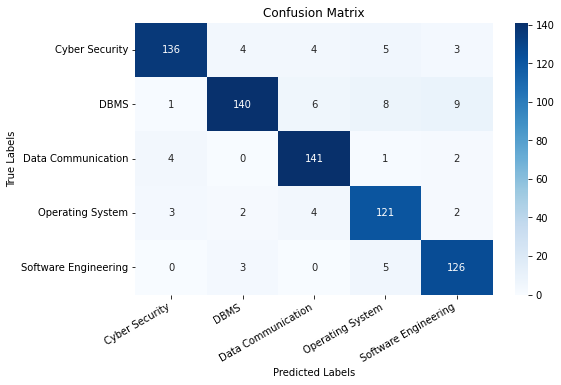

In [ ]:
# Import necessary packages
import ktrain
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats


# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# Rotate x-axis tick labels by 30 degrees
plt.xticks(rotation=30, ha='right')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_name = 'distilbert/distilbert-base-multilingual-cased'
trans = text.Transformer(model_name,maxlen=100,class_names=categories)

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)

preprocessing train...
language: bn
train sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 26


Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 25


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=32)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,classes = np.unique(train_data['enc_label'])
                                               ,y = train_data['enc_label'])
class_weights = dict(zip(np.unique(train_data['enc_label']), class_weights))

In [ ]:
weight = {i : class_weights[i] for i in range(5)}
weight

{0: 1.0156521739130435,
 1: 1.0656934306569343,
 2: 0.9426957223567393,
 3: 0.9175176747839748,
 4: 1.0794824399260627}

In [ ]:
learner.fit_onecycle(2e-5,10,class_weight=weight)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
183/183 [==============================] - 51s 228ms/step - loss: 1.5781 - accuracy: 0.2962 - val_loss: 1.4235 - val_accuracy: 0.4575
Epoch 2/10
183/183 [==============================] - 40s 217ms/step - loss: 1.1346 - accuracy: 0.5983 - val_loss: 0.8188 - val_accuracy: 0.7205
Epoch 3/10
183/183 [==============================] - 40s 217ms/step - loss: 0.6874 - accuracy: 0.7711 - val_loss: 0.6676 - val_accuracy: 0.7877
Epoch 4/10
183/183 [==============================] - 40s 217ms/step - loss: 0.4944 - accuracy: 0.8392 - val_loss: 0.5413 - val_accuracy: 0.8082
Epoch 5/10
183/183 [==============================] - 40s 217ms/step - loss: 0.3387 - accuracy: 0.8945 - val_loss: 0.5041 - val_accuracy: 0.8534
Epoch 6/10
183/183 [==============================] - 40s 217ms/step - loss: 0.2519 - accuracy: 0.9219 - val_loss: 0.4698 - val_accuracy: 0.8534
Epoch 7/10
183/183 [==============================] - 40s 217ms/ste

In [ ]:
# Save the predictor directly in the working directory
save_path = '/kaggle/working/dismbert'
ktrain.get_predictor(learner.model, preproc=trans).save(save_path)

In [ ]:
# Import necessary packages
from sklearn.metrics import accuracy_score, classification_report
import ktrain

# Specify the file path for saving and loading the model in the Kaggle working directory
save_path = '/kaggle/working/dismbert'

# Load the predictor from the specified path
predictor = ktrain.load_predictor(save_path)

# Assuming you have your test data available as 'X_test' and 'y_test' in your Kaggle environment
# Make predictions on the test data using the loaded predictor
y_pred = predictor.predict(X_test)

# Calculate accuracy by comparing the predicted labels with true labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Test data accuracy: {accuracy:.2%}")

# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(report)

Test data accuracy: 87.95%
Classification Report:
                      precision    recall  f1-score   support

      Cyber Security       0.86      0.88      0.87       152
                DBMS       0.90      0.85      0.87       164
  Data Communication       0.88      0.92      0.90       148
    Operating System       0.88      0.86      0.87       132
Software Engineering       0.88      0.89      0.88       134

            accuracy                           0.88       730
           macro avg       0.88      0.88      0.88       730
        weighted avg       0.88      0.88      0.88       730



In [ ]:
# Import necessary packages
import ktrain
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats

# Load the predictors (models) from the specified directories
predictor_banglabert = ktrain.load_predictor('/kaggle/working/banglabert')
predictor_roberta = ktrain.load_predictor('/kaggle/working/roberta')
predictor_mbert = ktrain.load_predictor('/kaggle/working/mbert')
predictor_disbert = ktrain.load_predictor('/kaggle/working/dismbert')

# Assuming you have your test data available as 'X_test' and 'y_test'
# Make predictions on the test data using each of the loaded predictors
y_pred_banglabert = predictor_banglabert.predict(X_test)
y_pred_roberta = predictor_roberta.predict(X_test)
y_pred_mbert = predictor_mbert.predict(X_test)
y_pred_disbert = predictor_disbert.predict(X_test)
# Ensemble the predictions using majority voting
# Majority voting: For each sample, choose the most common prediction among the models
y_pred_ensemble = stats.mode([y_pred_banglabert, y_pred_roberta, y_pred_mbert,y_pred_disbert], axis=0)[0][0]

# Calculate accuracy by comparing the ensemble predictions with true labels
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble test data accuracy: {accuracy:.2%}")

# Generate classification report for the ensemble predictions
report = classification_report(y_test, y_pred_ensemble,digits=4)

# Print the classification report
print("Ensemble classification report:")
print(report)


Ensemble test data accuracy: 91.92%
Ensemble classification report:
                      precision    recall  f1-score   support

      Cyber Security     0.9211    0.9211    0.9211       152
                DBMS     0.9074    0.8963    0.9018       164
  Data Communication     0.9400    0.9527    0.9463       148
    Operating System     0.8815    0.9015    0.8914       132
Software Engineering     0.9466    0.9254    0.9358       134

            accuracy                         0.9192       730
           macro avg     0.9193    0.9194    0.9193       730
        weighted avg     0.9194    0.9192    0.9192       730



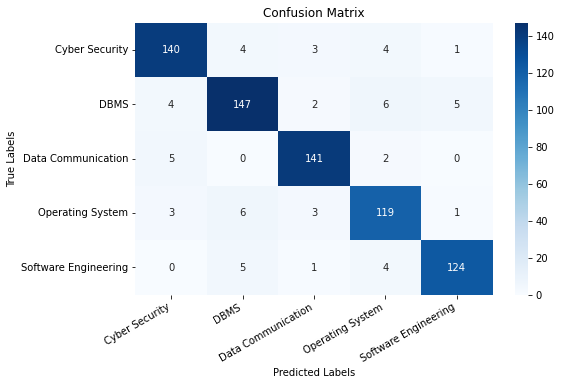

In [ ]:

# Import necessary packages
import ktrain
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats


# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

# Plot confusion matrix using seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# Rotate x-axis tick labels by 30 degrees
plt.xticks(rotation=30, ha='right')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Assuming 'X_test' is your test data, 'y_test' are the true labels, and 'y_pred_ensemble' are the ensemble predictions

# Find indices of misclassified samples
misclassified_indices = np.where(y_test != y_pred_ensemble)[0]

# Print or inspect misclassified samples
print("Misclassified samples:")
for idx in misclassified_indices:
    print(f"Index: {idx}")
    print(f"True Label: {y_test[idx]}")
    print(f"Predicted Label: {y_pred_ensemble[idx]}")
    print(f"Sample Data: {X_test[idx]}")
    print("-" * 30)

# If 'X_test' is a DataFrame and you want to see the misclassified samples in tabular form
import pandas as pd

# Assuming X_test is a DataFrame
misclassified_samples = X_test.iloc[misclassified_indices]
misclassified_samples['True_Label'] = y_test[misclassified_indices]
misclassified_samples['Predicted_Label'] = y_pred_ensemble[misclassified_indices]

print("Misclassified samples in tabular form:")
print(misclassified_samples)

Misclassified samples:
Index: 0
True Label: Cyber Security
Predicted Label: Data Communication
Sample Data: হার্ডওয়্যার ফায়ারওয়াল আরেকটি অসুবিধা সংস্থার ডিজাইন ফায়ারওয়াল গুলো কনফিগারেশনের হয়ে
------------------------------
Index: 5
True Label: DBMS
Predicted Label: Software Engineering
Sample Data: আপ্লিকেশন প্রোগ্রামের প্রভাব ছাড়াই সহজে পরিবর্তিত
------------------------------
Index: 12
True Label: Cyber Security
Predicted Label: Operating System
Sample Data: বছরগুলো পূর্বে প্রধানগুলি কম্পিউটিং মেইনফ্রেম কম্পিউটারে হতো ডেটা প্রসেসিং সেন্টারগুলি রক্ষা দায়িত্ব পরিদর্শন করতো
------------------------------
Index: 14
True Label: Software Engineering
Predicted Label: Operating System
Sample Data: এক্ষেত্রে প্রতিটি চক্রেই বৈশিষ্ট্য সমূহ সফটওয়্যারে যুক্ত পূর্বের চক্রের তুলনায় পরবর্তী চক্র capability সম্পন্ন
------------------------------
Index: 17
True Label: DBMS
Predicted Label: Operating System
Sample Data: যেহেতু প্রোগ্রামাররা দীর্ঘ সময় ফাইল অ্যাপ্লিকেশন প্রোগ্রাম তৈরি ফাইল থাকার সম্ভাব

AttributeError: 'list' object has no attribute 'iloc'

In [ ]:
test_data.to_csv('/kaggle/working/test_data.csv', index=False)

# Print message to indicate that the file has been saved
print("Test data saved to '/kaggle/working/test_data.csv'")

Test data saved to '/kaggle/working/test_data.csv'


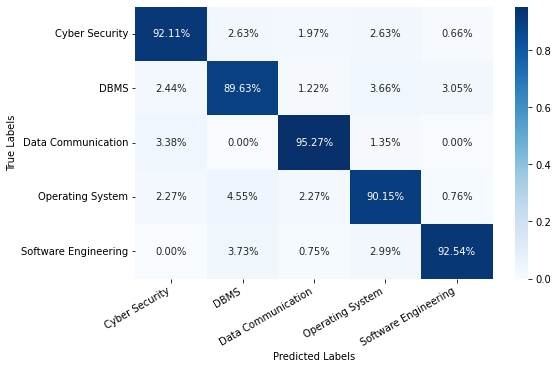

In [ ]:
# Import necessary packages
import ktrain
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats

# Assuming you have already made predictions and calculated the confusion matrix

# Normalize the confusion matrix by the total number of samples
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with percentages using seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# Rotate x-axis tick labels by 30 degrees
plt.xticks(rotation=30, ha='right')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()